In [ ]:
import os
import torch
import numpy as np
from transformers import pipeline
from PIL import Image

def generate_depth_map(image_path, output_size=(512, 512)):
    """
    Generates a depth map from an input image using a pre-trained model.

    Args:
        image_path (str): The path to the input image file.
        output_size (tuple): The desired output size for the depth map (width, height).

    Returns:
        PIL.Image.Image: The generated depth map as a PIL Image (normalized to 0-255).
                         Returns None if the input image cannot be processed.
    """
    # Initialize the depth estimation pipeline
    # Using device=0 for GPU if available, otherwise will use CPU
    try:
        depth_estimator = pipeline(
            "depth-estimation",
            model="Intel/dpt-large",
            torch_dtype=torch.float16, # Use float16 for potentially faster inference on GPU
            device=0 if torch.cuda.is_available() else "cpu"
        )
    except Exception as e:
        print(f"Error initializing depth estimation pipeline: {e}")
        return None

    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert("RGB")
        image = image.resize(output_size)
    except FileNotFoundError:
        print(f"Error: Input image not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error loading or resizing image: {e}")
        return None

    # Generate the depth map
    try:
        depth_map = depth_estimator(image)["depth"]
    except Exception as e:
        print(f"Error generating depth map: {e}")
        return None

    # Convert depth map to a normalized 8-bit image
    # The raw depth map values can be in various ranges, normalize to 0-255
    d_np = np.array(depth_map)
    # Avoid division by zero if the depth map is flat
    if d_np.max() - d_np.min() > 0:
        d_np = ((d_np - d_np.min()) / (d_np.max() - d_np.min()) * 255).astype(np.uint8)
    else:
        d_np = np.zeros_like(d_np, dtype=np.uint8) # Handle flat depth maps

    # Convert the numpy array back to a PIL Image (create a 3-channel image for consistency)
    depth_img = Image.fromarray(np.stack([d_np] * 3, axis=-1))

    return depth_img

input_image_path = "output/images/04-20_03-30_vae_train_imgs/epoch_66/train_image_150.png"

# --- Example Usage ---
if __name__ == "__main__":
    # This path is based on the input directory structure from your previous code.
    output_depth_map_path = "output/images/output_depth_map.png"

    # The dummy image creation part is removed as we are using a specific path now.
    # If the path above does not exist, the script will print an error.

    if os.path.exists(input_image_path):
        print(f"Generating depth map for {input_image_path}...")
        depth_map_image = generate_depth_map(input_image_path)

        if depth_map_image:
            try:
                depth_map_image.save(output_depth_map_path)
                print(f"Depth map saved to {output_depth_map_path}")
            except Exception as e:
                print(f"Error saving depth map: {e}")
        else:
            print("Depth map generation failed.")
    else:
        print(f"Error: Input image not found at {input_image_path}. Please update the 'input_image_path' variable.")



Generating depth map for /DATA/deep_learning/04-20_03-30_vae_train_imgs/epoch_66/train_image_150.png...


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Depth map saved to output_depth_map.png


In [108]:
import cv2
import numpy as np

def apply_gaussian_blur(depth_map, ksize=(5, 5), sigmaX=0):
  """Applies Gaussian blur to a depth map.

  Args:
    depth_map: Input depth map (NumPy array).
    ksize: Gaussian kernel size (width, height).
    sigmaX: Gaussian kernel standard deviation in X direction.

  Returns:
    Blurred depth map (NumPy array).
  """
  # Ensure depth map is in a suitable format (e.g., float32) for processing
  depth_map = depth_map.astype(np.float32)
  blurred_depth_map = cv2.GaussianBlur(depth_map, ksize, sigmaX)
  return blurred_depth_map

# Example usage:
# Assuming 'your_depth_map' is your input depth map as a NumPy array
# blurred_map = apply_gaussian_blur(your_depth_map, ksize=(9, 9), sigmaX=2)

import math

def introduce_depth_holes(depth_map, hole_percentage=0.1, hole_size_range=(10, 50)):
    """Introduces random rectangular 'holes' of invalid depth values."""
    noisy_depth_map = np.copy(depth_map)
    rows, cols = depth_map.shape
    num_holes = int(rows * cols * hole_percentage / (np.mean(hole_size_range)**2)) # Estimate number of holes

    for _ in range(num_holes):
        # Randomly determine hole size
        hole_h = np.random.randint(hole_size_range[0], hole_size_range[1] + 1)
        hole_w = np.random.randint(hole_size_range[0], hole_size_range[1] + 1)

        # Randomly determine hole position
        y = np.random.randint(0, rows - hole_h + 1)
        x = np.random.randint(0, cols - hole_w + 1)

        # Set the region to an invalid value (e.g., 0 or NaN)
        # Use NaN if your pipeline can handle it, otherwise use a specific value
        noisy_depth_map[y:y+hole_h, x:x+hole_w] = 0 # Using NaN as an example

    return noisy_depth_map

def apply_motion_blur(depth_map, kernel_size=15, angle=45):
  """Applies motion blur to a depth map.

  Args:
    depth_map: Input depth map (NumPy array).
    kernel_size: The size of the motion blur kernel.
    angle: The angle of the motion blur in degrees.

  Returns:
    Blurred depth map (NumPy array).
  """
  # Ensure depth map is in a suitable format
  depth_map = depth_map.astype(np.float32)

  # Create the motion blur kernel
  kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
  if angle == 0:
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
  elif angle == 90:
    kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
  else:
    # Approximate diagonal motion blur
    # This is a simplified approximation and can be improved
    # For more accurate motion blur, consider specialized libraries or methods
    for i in range(kernel_size):
        j = int(i * math.tan(math.radians(angle)))
        if 0 <= j < kernel_size:
            kernel[i, j] = 1
            
  kernel /= np.sum(kernel) # Normalize the kernel

  # Apply the kernel
  blurred_depth_map = cv2.filter2D(depth_map, -1, kernel)
  return blurred_depth_map

# Example usage:
# blurred_map = apply_motion_blur(your_depth_map, kernel_size=25, angle=30)

In [109]:
import cv2
import numpy as np

def apply_average_blur(depth_map, ksize=(10, 10)):
  """Applies average blur to a depth map.

  Args:
    depth_map: Input depth map (NumPy array).
    ksize: Kernel size (width, height).

  Returns:
    Blurred depth map (NumPy array).
  """
  # Ensure depth map is in a suitable format
  depth_map = depth_map.astype(np.float32)
  blurred_depth_map = cv2.blur(depth_map, ksize)
  return blurred_depth_map

# Example usage:
# blurred_map = apply_average_blur(your_depth_map, ksize=(15, 15))

import numpy as np
# Make sure to install the 'noise' library: pip install noise
import noise

def add_perlin_noise(depth_map, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0, seed=None):
    """Adds Perlin noise to a depth map."""
    # Ensure depth map is in a suitable format (e.g., float32)
    depth_map = depth_map.astype(np.float32)
    rows, cols = depth_map.shape
    perlin_noise = np.zeros((rows, cols))

    if seed is None:
        seed = np.random.randint(0, 100) # Generate a random seed if none provided

    # Generate Perlin noise
    for i in range(rows):
        for j in range(cols):
            perlin_noise[i][j] = noise.pnoise2(i/scale,
                                               j/scale,
                                               octaves=octaves,
                                               persistence=persistence,
                                               lacunarity=lacunarity,
                                               repeatx=1024, # Adjust repeatx/y based on your image size
                                               repeaty=1024,
                                               base=seed)

    # Normalize Perlin noise to a desired range (e.g., -1 to 1 or 0 to 1)
    # Then scale it to affect the depth values
    noise_range = np.max(perlin_noise) - np.min(perlin_noise)
    if noise_range > 0:
        perlin_noise = 2 * (perlin_noise - np.min(perlin_noise)) / noise_range - 1 # Normalize to [-1, 1]

    # Add the scaled Perlin noise to the depth map
    # You might need to adjust the scaling factor (e.g., multiplying perlin_noise by a small value)
    # to control the intensity of the effect.
    noisy_depth_map = depth_map + perlin_noise * (np.max(depth_map) * 0.05) # Example scaling by 5% of max depth

    return noisy_depth_map

# Example usage:
# noisy_map = add_perlin_noise(your_depth_map, scale=50.0, octaves=4)

Successfully loaded depth map from output_depth_map.png


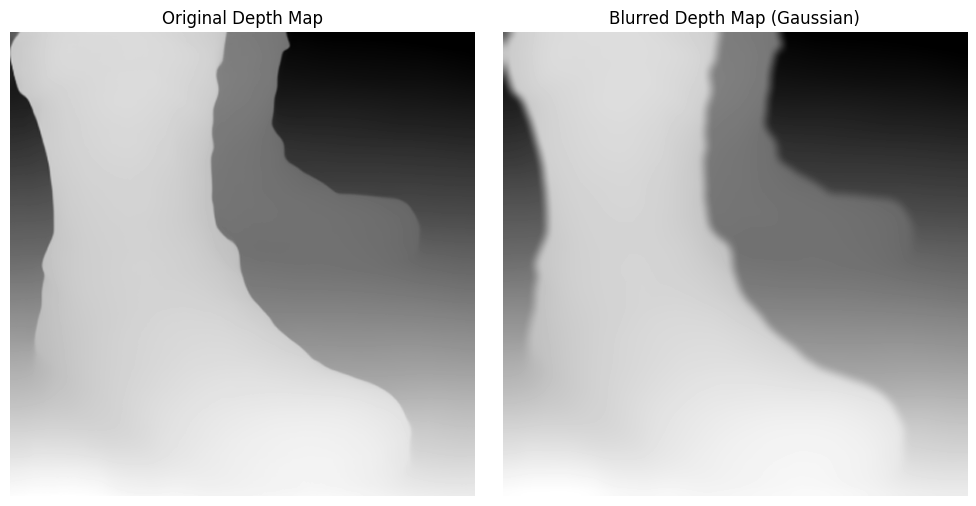

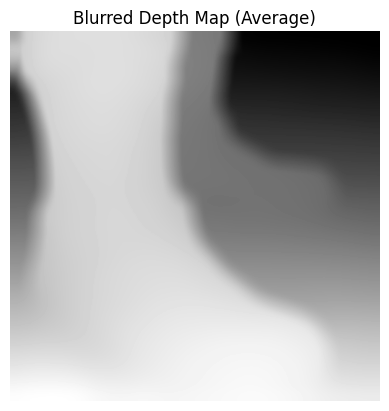

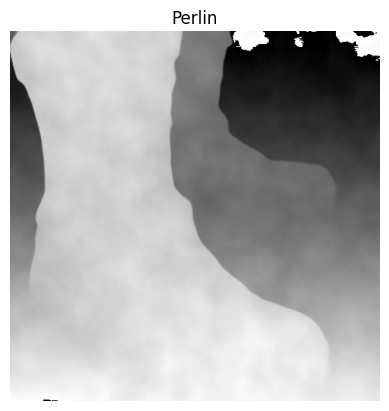

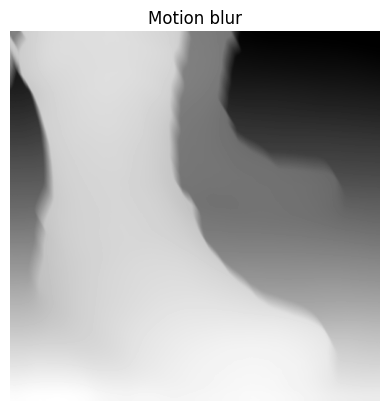

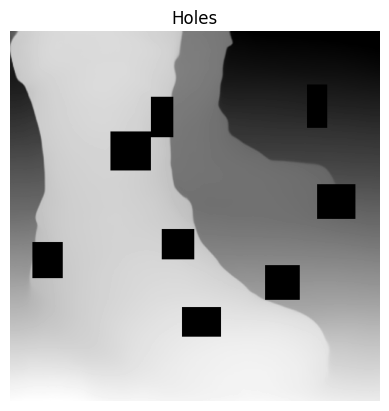

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Import matplotlib for displaying images

# Assume the blur functions (apply_gaussian_blur, apply_average_blur, etc.)
# from our previous discussion are available or defined here.
# For demonstration, let's include a simple Gaussian blur function:
def apply_gaussian_blur(depth_map, ksize=(5, 5), sigmaX=0):
  """Applies Gaussian blur to a depth map."""
  # Ensure depth map is in a suitable format (e.g., float32) for processing
  # OpenCV blur functions typically work with various types, but float32 is good practice
  depth_map = depth_map.astype(np.float32)
  blurred_depth_map = cv2.GaussianBlur(depth_map, ksize, sigmaX)
  return blurred_depth_map

# --- Main part of the script ---

# Define the path to the saved depth map image
# This should match the output_depth_map_path from the previous script
depth_map_path = "output/images/output_depth_map.png"

# Load the depth map image using OpenCV
# Use cv2.IMREAD_UNCHANGED to load all channels (important if saved as color)
# or cv2.IMREAD_GRAYSCALE if you normalized to a single channel depth image
# Based on the previous script, it was saved as a 3-channel image.
original_depth_map_color = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)

# Check if the image was loaded successfully
if original_depth_map_color is None:
    print(f"Error: Could not load the image from {depth_map_path}")
else:
    print(f"Successfully loaded depth map from {depth_map_path}")

    # If the image is 3 channels (color), you might want to work with a single channel
    # for depth values, or apply blur to all channels depending on your need.
    # Assuming the depth information is the same across the 3 channels saved previously:
    original_depth_map_gray = original_depth_map_color[:, :, 0] # Take one channel

    # --- Apply Blur ---
    # Now you can call the blur functions here.
    # For example, applying Gaussian blur:
    blurred_depth_map = apply_gaussian_blur(original_depth_map_gray, ksize=(15, 15), sigmaX=5)

    perlin_added_depth = add_perlin_noise(original_depth_map_gray, scale=50.0, octaves=4)
    # --- Visualize Changes using Matplotlib ---
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    plt.imshow(original_depth_map_gray, cmap='gray') # Use cmap='gray' for grayscale images
    plt.title("Original Depth Map")
    plt.axis('off') # Hide axes

    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
    plt.imshow(blurred_depth_map.astype(np.uint8), cmap='gray') # Cast back to uint8 and use cmap='gray'
    plt.title("Blurred Depth Map (Gaussian)")
    plt.axis('off') # Hide axes

    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show() # Display the plot

    # You can apply other blur types here and display them similarly:
    blurred_avg = apply_average_blur(original_depth_map_gray, ksize=(30, 30))
    plt.figure()
    plt.imshow(blurred_avg.astype(np.uint8), cmap='gray')
    plt.title("Blurred Depth Map (Average)")
    plt.axis('off')
    plt.show()

    # blurred_motion = apply_motion_blur(original_depth_map_gray, kernel_size=20, angle=45)
    plt.figure()
    plt.imshow(perlin_added_depth.astype(np.uint8), cmap='gray')
    plt.title("Perlin")
    plt.axis('off')
    plt.show()

    motion_blurred_map = apply_motion_blur(original_depth_map_gray, kernel_size=25, angle=30)
    plt.figure()
    plt.imshow(motion_blurred_map.astype(np.uint8), cmap='gray')
    plt.title("Motion blur")
    plt.axis('off')
    plt.show()



    holed_depth_map = introduce_depth_holes(original_depth_map_gray, hole_percentage=0.05, hole_size_range=(20, 60))
    plt.figure()
    plt.imshow(holed_depth_map.astype(np.uint8), cmap='gray')
    plt.title("Holes")
    plt.axis('off')
    plt.show()




Successfully loaded depth map from output_depth_map.png


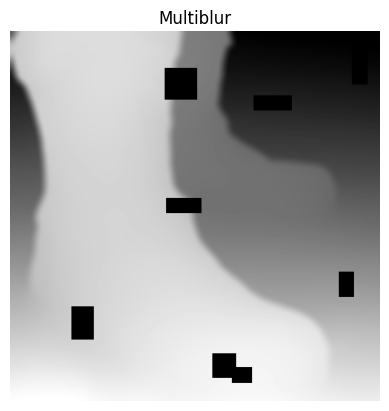

In [ ]:

depth_map_path = "output/images/output_depth_map.png"

original_depth_map_color = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)


if original_depth_map_color is None:
    print(f"Error: Could not load the image from {depth_map_path}")
else:
    print(f"Successfully loaded depth map from {depth_map_path}")

    original_depth_map_gray = original_depth_map_color[:, :, 0] 

    blurred_depth_map = apply_gaussian_blur(original_depth_map_gray, ksize=(15, 15), sigmaX=5)

    #perlin_added_depth = add_perlin_noise(blurred_depth_map, scale=20.0, octaves=4)

    holed_depth_map = introduce_depth_holes(blurred_depth_map, hole_percentage=0.05, hole_size_range=(20, 60))
    

    plt.figure()
    plt.imshow(holed_depth_map.astype(np.uint8), cmap='gray')
    plt.title("Multiblur")
    plt.axis('off')
    plt.show()

    blurred_depth_map_path = "blurred_output_depth_map_gaussian.png"
    cv2.imwrite(blurred_depth_map_path, holed_depth_map)

In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import torch
import torchvision.transforms.functional as TF
import lpips # Make sure you have lpips installed: pip install lpips
from pytorch_msssim import ms_ssim # Make sure you have pytorch-msssim installed: pip install pytorch-msssim

# Initialize LPIPS model (needs to be done once)
try:
    lpips_fn = lpips.LPIPS(net="alex").to("cuda" if torch.cuda.is_available() else "cpu")
except Exception as e:
    print(f"Warning: Could not initialize LPIPS model. LPIPS metric will be skipped. Error: {e}")
    lpips_fn = None


def calculate_image_metrics(image1_path, image2_path):

    img1_np = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2_np = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    if img1_np is None:
        print(f"Error: Could not load image from {image1_path}")
        return None
    if img2_np is None:
        print(f"Error: Could not load image from {image2_path}")
        return None

    if img1_np.shape != img2_np.shape:
        print("Error: Images must have the same dimensions for comparison.")
        # Optionally resize one to match the other, but be aware this affects metrics
        # img2_np = cv2.resize(img2_np, (img1_np.shape[1], img1_np.shape[0]))
        # print("Warning: Resized the second image to match the first.")
        return None

    img1_float = img1_np.astype(np.float32)
    img2_float = img2_np.astype(np.float32)

    # --- Calculate Metrics ---

    # PSNR (Peak Signal-to-Noise Ratio)
    # Data range is typically 255 for 8-bit images
    _psnr = psnr(img1_float, img2_float, data_range=255)

    # SSIM (Structural Similarity Index)
    # channel_axis=None for grayscale images
    _ssim = ssim(img1_float, img2_float, data_range=255, channel_axis=None, win_size=7) # win_size should be odd, default is 7

    # MS-SSIM (Multi-Scale Structural Similarity Index)
    # Requires PyTorch tensors and values normalized between 0 and 1
    img1_t = TF.to_tensor(img1_np).unsqueeze(0) # Add batch dimension
    img2_t = TF.to_tensor(img2_np).unsqueeze(0)

    # Move tensors to GPU if available for MS-SSIM and LPIPS
    device = "cuda" if torch.cuda.is_available() else "cpu"
    img1_t = img1_t.to(device)
    img2_t = img2_t.to(device)

    _mssim = ms_ssim(img1_t, img2_t, data_range=1.0, size_average=True).item()

    # LPIPS (Learned Perceptual Image Patch Similarity)
    # Requires values between -1 and 1
    _lpips = None
    if lpips_fn:
        # Normalize to [-1, 1]
        img1_lp = img1_t * 2 - 1
        img2_lp = img2_t * 2 - 1
        _lpips = lpips_fn(img1_lp, img2_lp).item()

    metrics = {
        "PSNR": _psnr,
        "SSIM": _ssim,
        "MS-SSIM": _mssim,
        "LPIPS": _lpips 
    }

    return metrics

if __name__ == "__main__":

    original_depth_map_path = "output/images/output_depth_map.png"
    blurred_depth_map_path = "output/images/blurred_output_depth_map_gaussian.png" 

    if not os.path.exists(blurred_depth_map_path):
        print(f"Creating a dummy blurred image at {blurred_depth_map_path} for demonstration.")
        original_img = cv2.imread(original_depth_map_path, cv2.IMREAD_GRAYSCALE)
        if original_img is not None:
            # Apply a simple blur to the dummy image
            dummy_blurred_img = cv2.GaussianBlur(original_img, (25, 25), 0)
            cv2.imwrite(blurred_depth_map_path, dummy_blurred_img)
            print("Dummy blurred image created.")
        else:
            print(f"Could not load original image from {original_depth_map_path} to create dummy blurred image.")
            blurred_depth_map_path = None # Cannot proceed if no original image

    # --- Calculate and print metrics ---
    if os.path.exists(original_depth_map_path) and blurred_depth_map_path and os.path.exists(blurred_depth_map_path):
        print(f"\nComparing {original_depth_map_path} and {blurred_depth_map_path}:")
        similarity_metrics = calculate_image_metrics(original_depth_map_path, blurred_depth_map_path)

        if similarity_metrics:
            for metric_name, value in similarity_metrics.items():
                if value is not None:
                    print(f"{metric_name}: {value:.4f}")
                else:
                    print(f"{metric_name}: Calculation skipped (e.g., LPIPS model not loaded)")
        else:
            print("Metric calculation failed.")
    else:
         print("\nCould not find one or both images for metric calculation. Please ensure paths are correct.")



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /DATA/deep_learning/dependencies/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth

Comparing output_depth_map.png and blurred_output_depth_map_gaussian.png:
PSNR: 18.1975
SSIM: 0.9329
MS-SSIM: 0.8696
LPIPS: 0.3099


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokeniz

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokeniz

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, token

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /DATA/deep_learning/dependencies/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Processing image: /DATA/deep_learning/04-20_03-30_vae_train_imgs/epoch_66/train_image_150.png
Using prompt: A high-quality photograph
Enhancing with depth...


  0%|          | 0/16 [00:00<?, ?it/s]

Enhancing with blurred depth...


  0%|          | 0/16 [00:00<?, ?it/s]

Enhancing without depth (standard img2img)...


  0%|          | 0/16 [00:00<?, ?it/s]


--- Results ---

-- With Depth --
PSNR   : 17.6728
SSIM   : 0.4289
MS-SSIM: 0.5310
LPIPS  : 0.4262

-- With Blurred Depth --
PSNR   : 15.6546
SSIM   : 0.3682
MS-SSIM: 0.4258
LPIPS  : 0.4614

-- Without Depth --
PSNR   : 17.2533
SSIM   : 0.4029
MS-SSIM: 0.4198
LPIPS  : 0.4722

Displaying images...


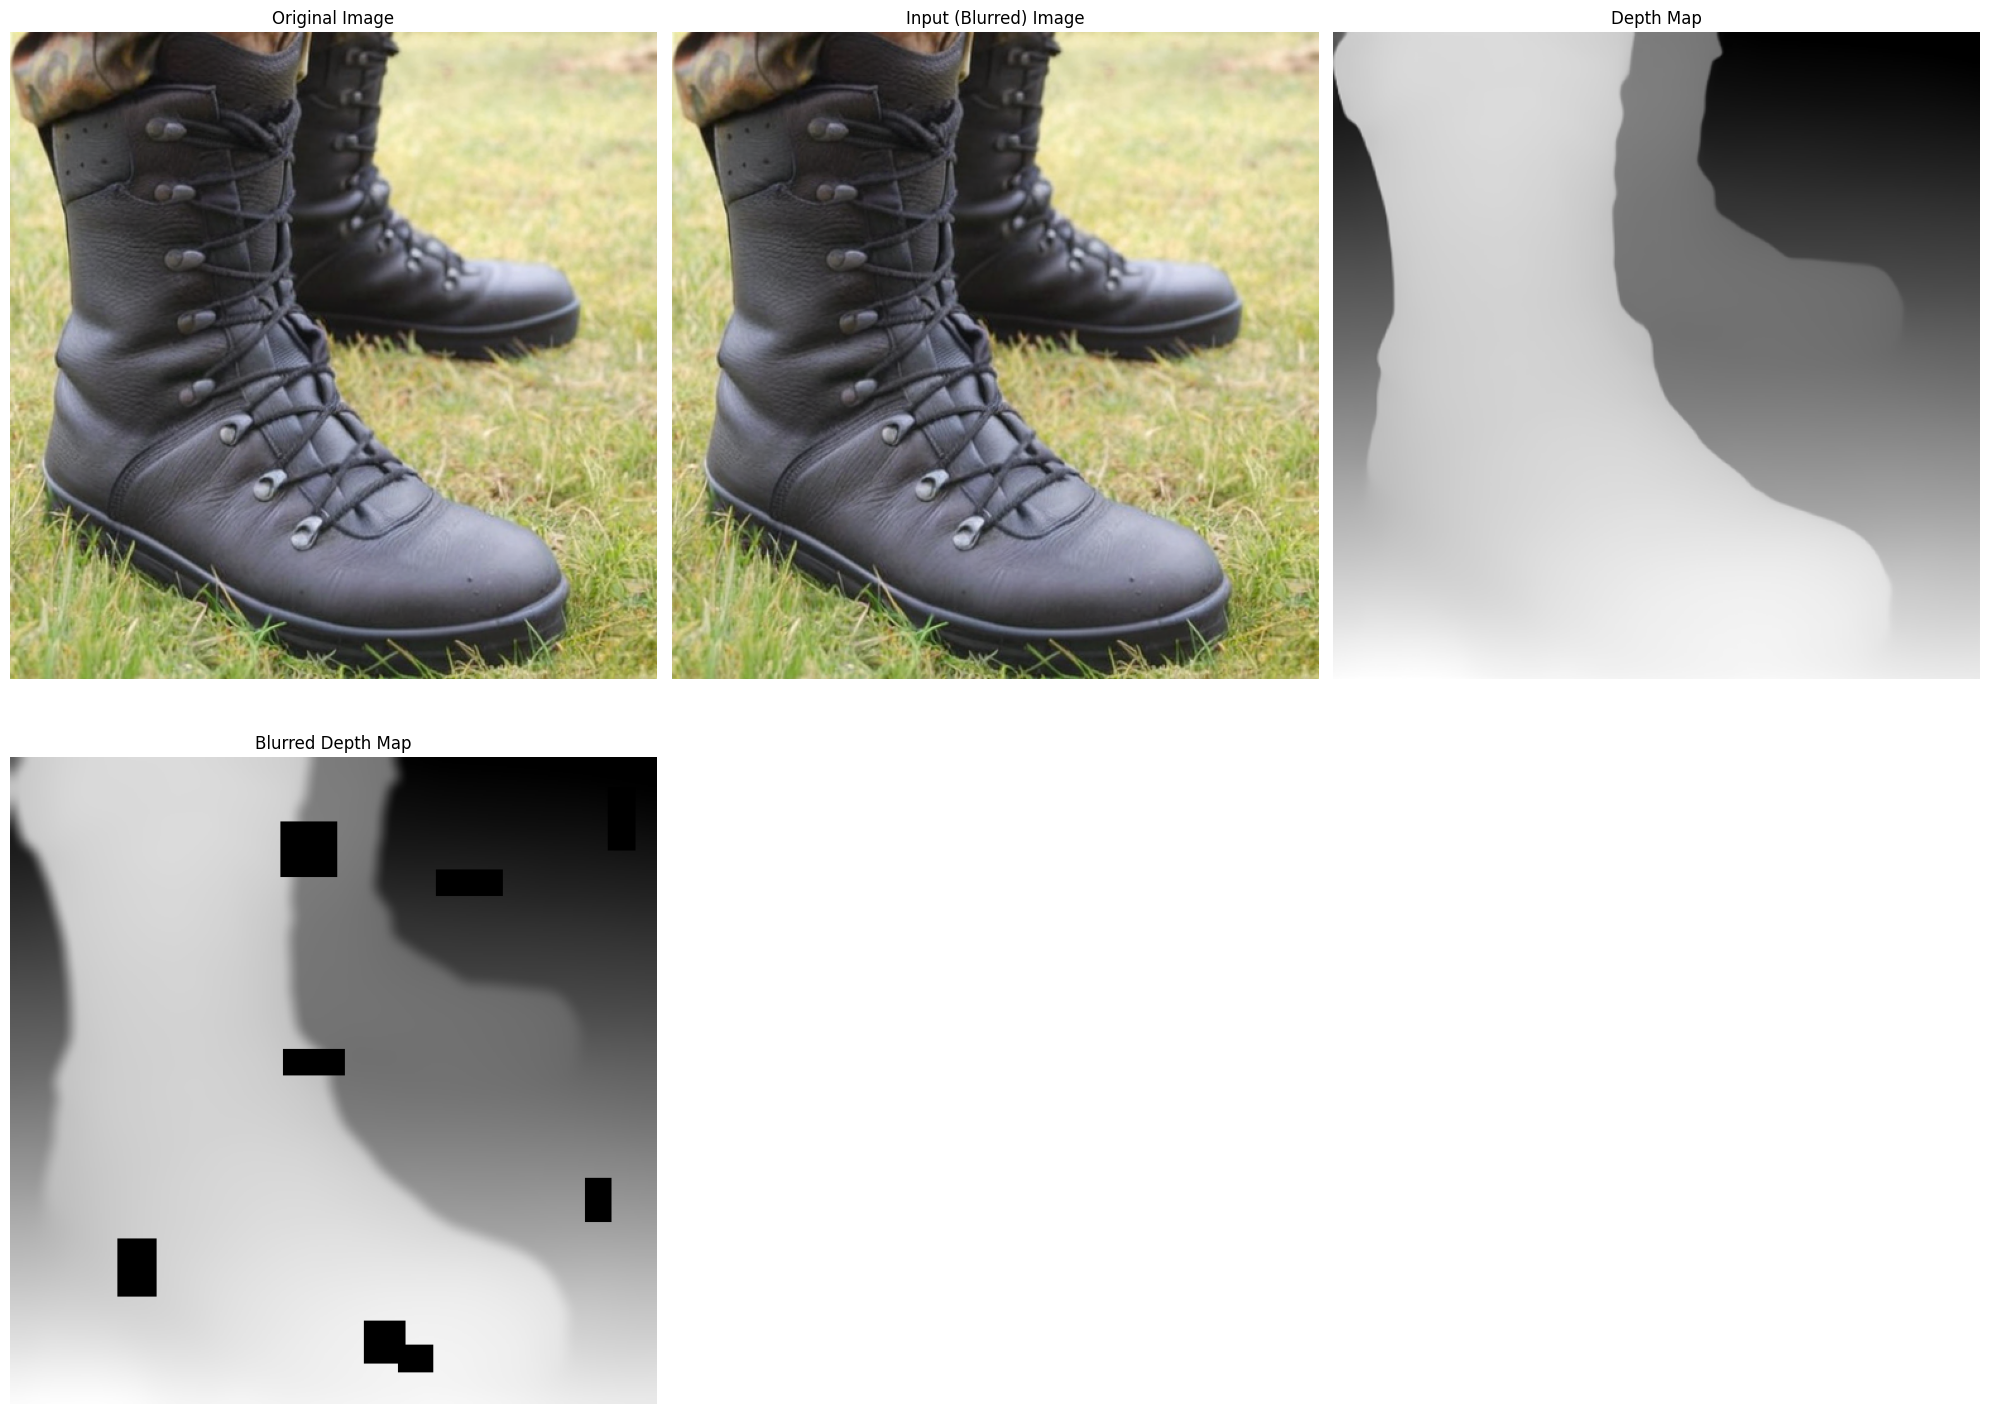

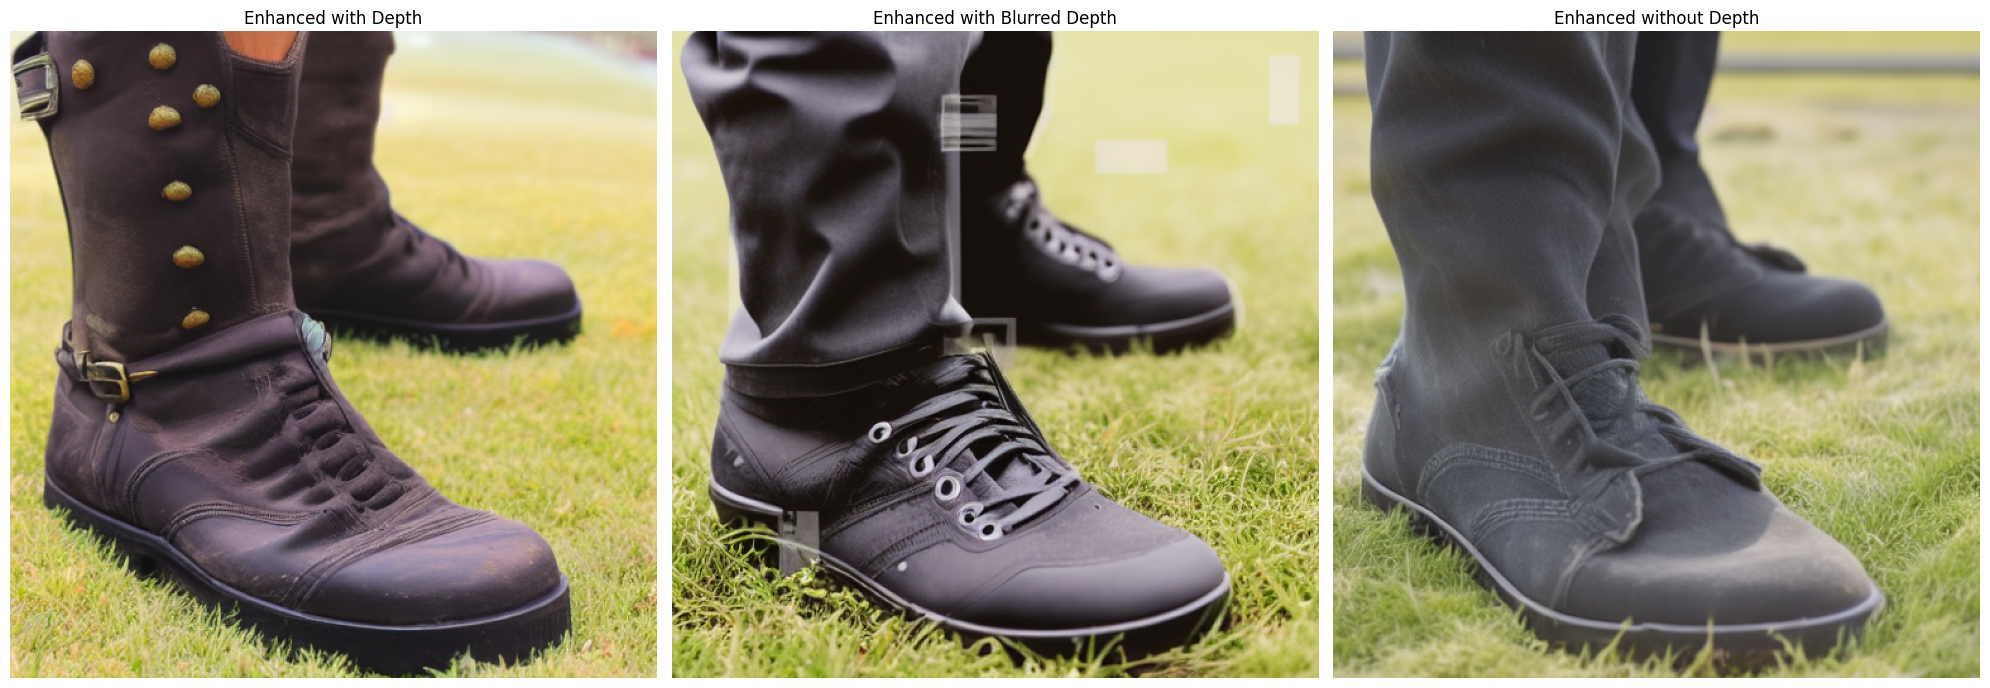


Processing finished.


In [ ]:
import os
import torch
from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetImg2ImgPipeline,
    StableDiffusionImg2ImgPipeline,
    UniPCMultistepScheduler
)
from PIL import Image, ImageFilter
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from pytorch_msssim import ms_ssim
import lpips
import torchvision.transforms.functional as TF
# Import IPython display functions for Jupyter
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# -----------------------------
# 1. Setup pipelines/models
# -----------------------------
# ControlNet-guided Img2Img
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float16
)
pipe_with_depth = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)
pipe_with_depth.scheduler = UniPCMultistepScheduler.from_config(pipe_with_depth.scheduler.config)
pipe_with_depth.enable_xformers_memory_efficient_attention()
pipe_with_depth.enable_model_cpu_offload()
pipe_with_depth.to("cuda")

pipe_with_blurreddepth = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)
pipe_with_blurreddepth.scheduler = UniPCMultistepScheduler.from_config(pipe_with_depth.scheduler.config)
pipe_with_blurreddepth.enable_xformers_memory_efficient_attention()
pipe_with_blurreddepth.enable_model_cpu_offload()
pipe_with_blurreddepth.to("cuda")

# Standard Img2Img (no depth)
pipe_without_depth = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    torch_dtype=torch.float16
)
pipe_without_depth.scheduler = UniPCMultistepScheduler.from_config(pipe_without_depth.scheduler.config)
pipe_without_depth.enable_xformers_memory_efficient_attention()
pipe_without_depth.enable_model_cpu_offload()
pipe_without_depth.to("cuda")

# LPIPS model
lpips_fn = lpips.LPIPS(net="alex").to("cuda")

# -----------------------------
# 2. Metrics calculation
# -----------------------------

def calculate_metrics(orig: Image.Image, enhanced: Image.Image):
    orig_np = np.array(orig).astype(np.float32)
    enh_np  = np.array(enhanced).astype(np.float32)
    _psnr   = psnr(orig_np, enh_np, data_range=255)
    _ssim   = ssim(orig_np, enh_np, data_range=255, channel_axis=-1, win_size=7)
    orig_t  = TF.to_tensor(orig).unsqueeze(0).to("cuda")
    enh_t   = TF.to_tensor(enhanced).unsqueeze(0).to("cuda")
    _mssim  = ms_ssim(orig_t, enh_t, data_range=1.0, size_average=True).item()
    orig_lp = orig_t * 2 - 1
    enh_lp  = enh_t  * 2 - 1
    _lpips  = lpips_fn(orig_lp, enh_lp).item()
    return {
        "PSNR":    _psnr,
        "SSIM":    _ssim,
        "MS-SSIM": _mssim,
        "LPIPS":   _lpips
    }

# Helper function to display multiple images in a grid
def display_images(images_dict, figsize=(20, 15), columns=3):
    """Display multiple images in a grid layout with titles"""
    n = len(images_dict)
    rows = (n + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, (title, img) in enumerate(images_dict.items()):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3. Single Image Processing
# -----------------------------

# Define input file paths and prompt
# --- USER: Please replace these paths with your actual file paths ---
#original_image_path = "/DATA/deep_learning/04-20_03-30_vae_train_imgs/epoch_99/train_image_473.png"
original_image_path = input_image_path
blurred_image_path = original_image_path
depth_map_path = "output/images/output_depth_map.png"
blurred_depth_map_path = "output/images/blurred_output_depth_map_gaussian.png"
prompt = "A high-quality photograph" # --- USER: Define your prompt ---
output_save_dir = "./single_output" # Optional: Directory to save results
os.makedirs(output_save_dir, exist_ok=True)

# --- Input Validation ---
if not os.path.exists(original_image_path):
    raise FileNotFoundError(f"Original image not found: {original_image_path}")
if not os.path.exists(blurred_image_path):
    raise FileNotFoundError(f"Blurred/Input image not found: {blurred_image_path}")
if not os.path.exists(depth_map_path):
    raise FileNotFoundError(f"Depth map not found: {depth_map_path}")
if not os.path.exists(blurred_depth_map_path):
    raise FileNotFoundError(f"Blurred depth map not found: {blurred_depth_map_path}")

# Load images
orig_img = Image.open(original_image_path).convert("RGB").resize((512, 512))
blur_img = Image.open(blurred_image_path).convert("RGB").resize((512, 512))
depth_img = Image.open(depth_map_path).convert("RGB").resize((512, 512))
blurred_depth_img = Image.open(blurred_depth_map_path).convert("RGB").resize((512, 512))

print(f"Processing image: {original_image_path}")
print(f"Using prompt: {prompt}")

# Enhance with depth
print("Enhancing with depth...")
out_with_depth = pipe_with_depth(
    prompt=prompt,
    image=blur_img,
    control_image=depth_img,
    num_inference_steps=20
).images[0]
out_with_depth.save(os.path.join(output_save_dir, "enhanced_with_depth.png"))
metrics_with_depth = calculate_metrics(orig_img, out_with_depth)

# Enhance with blurred depth
print("Enhancing with blurred depth...")
out_with_blurred_depth = pipe_with_blurreddepth(
    prompt=prompt,
    image=blur_img,
    control_image=blurred_depth_img,
    num_inference_steps=20
).images[0]
out_with_blurred_depth.save(os.path.join(output_save_dir, "enhanced_with_blurred_depth.png"))
metrics_with_blurred_depth = calculate_metrics(orig_img, out_with_blurred_depth)

# Enhance without depth
print("Enhancing without depth (standard img2img)...")
out_without_depth = pipe_without_depth(
    prompt=prompt,
    image=blur_img,
    num_inference_steps=20
).images[0]
out_without_depth.save(os.path.join(output_save_dir, "enhanced_without_depth.png"))
metrics_without_depth = calculate_metrics(orig_img, out_without_depth)

# -----------------------------
# 4. Display Results and Metrics
# -----------------------------

print("\n--- Results ---")

print("\n-- With Depth --")
for k, v in metrics_with_depth.items(): print(f"{k:7s}: {v:.4f}")
print("\n-- With Blurred Depth --")
for k, v in metrics_with_blurred_depth.items(): print(f"{k:7s}: {v:.4f}")
print("\n-- Without Depth --")
for k, v in metrics_without_depth.items(): print(f"{k:7s}: {v:.4f}")

# Display images in Jupyter notebook instead of external viewer
print("\nDisplaying images...")

# First, display input images
input_images = {
    "Original Image": orig_img,
    "Input (Blurred) Image": blur_img,
    "Depth Map": depth_img,
    "Blurred Depth Map": blurred_depth_img
}
display_images(input_images)

# Then, display output images
output_images = {
    "Enhanced with Depth": out_with_depth,
    "Enhanced with Blurred Depth": out_with_blurred_depth,
    "Enhanced without Depth": out_without_depth
}
display_images(output_images)

print("\nProcessing finished.")


In [114]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def weighted_blend_depth_maps(original_depth_map, blurred_depth_map, weight=0.5):
    """Combines an original depth map with a blurred version using weighted average.

    Args:
        original_depth_map: The original depth map (numpy array).
        blurred_depth_map: A pre-blurred depth map (numpy array).
        weight: Weight for the original image (0.0 to 1.0). Default is 0.5.
            - weight=1.0: Output = original depth map only
            - weight=0.0: Output = blurred depth map only
            - weight=0.5: Equal contribution from both images

    Returns:
        Weighted average of original and blurred depth maps (numpy array).
    """
    # Convert to float32 for more accurate calculations
    original = original_depth_map.astype(np.float32)
    blurred = blurred_depth_map.astype(np.float32)
    
    # Ensure weight is between 0 and 1
    weight = max(0.0, min(1.0, weight))
    
    # Calculate weighted average
    weighted_depth_map = (weight * original) + ((1 - weight) * blurred)
    
    # Return as the same dtype as the original
    return weighted_depth_map.astype(original_depth_map.dtype)

# # Example usage of the weighted blend function
# if __name__ == "__main__":
#     # Paths to the depth maps
#     original_depth_map_path = "output_depth_map.png"
#     blurred_depth_map_path = "blurred_output_depth_map_gaussian.png"
    
#     # Load both depth maps
#     original_depth_map_color = cv2.imread(original_depth_map_path, cv2.IMREAD_UNCHANGED)
#     blurred_depth_map_color = cv2.imread(blurred_depth_map_path, cv2.IMREAD_UNCHANGED)
    
#     if original_depth_map_color is None or blurred_depth_map_color is None:
#         print(f"Error: Could not load one or both of the depth maps.")
#     else:
#         # Convert to grayscale if they are color images
#         original_depth_map = original_depth_map_color[:, :, 0]
#         blurred_depth_map = blurred_depth_map_color[:, :, 0]
        
#         # Create weighted blends with different weights
#         weights = [0.2, 0.5, 0.8]
#         blended_maps = []
        
#         for weight in weights:
#             blended = weighted_blend_depth_maps(original_depth_map, blurred_depth_map, weight)
#             blended_maps.append((f"Weight {weight:.1f}", blended))
        
#         # Visualize the original, blurred and weighted blends
#         plt.figure(figsize=(15, 10))
        
#         # Original depth map
#         plt.subplot(2, 3, 1)
#         plt.imshow(original_depth_map, cmap='gray')
#         plt.title("Original Depth Map")
#         plt.axis('off')
        
#         # Blurred depth map
#         plt.subplot(2, 3, 4)
#         plt.imshow(blurred_depth_map, cmap='gray')
#         plt.title("Blurred Depth Map")
#         plt.axis('off')
        
#         # Weighted blends
#         for i, (title, blended) in enumerate(blended_maps):
#             plt.subplot(2, 3, i + 2)
#             plt.imshow(blended.astype(np.uint8), cmap='gray')
#             plt.title(f"Weighted Blend: {title}")
#             plt.axis('off')
        
#         plt.tight_layout()
#         plt.show()
        
#         # Save a selected weighted blend (e.g., weight=0.5)
#         selected_weight = 0.5
#         selected_blend = weighted_blend_depth_maps(original_depth_map, blurred_depth_map, selected_weight)
#         weighted_blend_path = f"weighted_depth_map_w{selected_weight:.1f}.png"
#         cv2.imwrite(weighted_blend_path, selected_blend)
#         print(f"Saved weighted blend with weight={selected_weight} to {weighted_blend_path}")
        
#         # You can also create a weight map for more advanced control
#         # This example creates a weight that varies from left to right
#         h, w = original_depth_map.shape
#         weight_map = np.tile(np.linspace(0, 1, w), (h, 1))  # Creates gradient from left to right
        
#         # Apply the weight map
#         spatial_weighted_blend = (weight_map * original_depth_map.astype(np.float32) + 
#                                   (1 - weight_map) * blurred_depth_map.astype(np.float32))
        
#         # Visualize the spatially varying blend
#         plt.figure(figsize=(15, 5))
        
#         plt.subplot(1, 3, 1)
#         plt.imshow(weight_map, cmap='viridis')
#         plt.title("Weight Map (Left to Right)")
#         plt.axis('off')
        
#         plt.subplot(1, 3, 2)
#         plt.imshow(spatial_weighted_blend.astype(np.uint8), cmap='gray')
#         plt.title("Spatially Varying Blend")
#         plt.axis('off')
        
#         plt.subplot(1, 3, 3)
#         # Display a difference to see the effect more clearly
#         diff = np.abs(spatial_weighted_blend - blurred_depth_map.astype(np.float32))
#         plt.imshow(diff.astype(np.uint8), cmap='hot')
#         plt.title("Difference from Blurred")
#         plt.axis('off')
        
#         plt.tight_layout()
#         plt.show()
        
#         # Save the spatially varying blend
#         spatial_weighted_path = "spatial_weighted_depth_map.png"
#         cv2.imwrite(spatial_weighted_path, spatial_weighted_blend.astype(np.uint8))
#         print(f"Saved spatially varying blend to {spatial_weighted_path}")

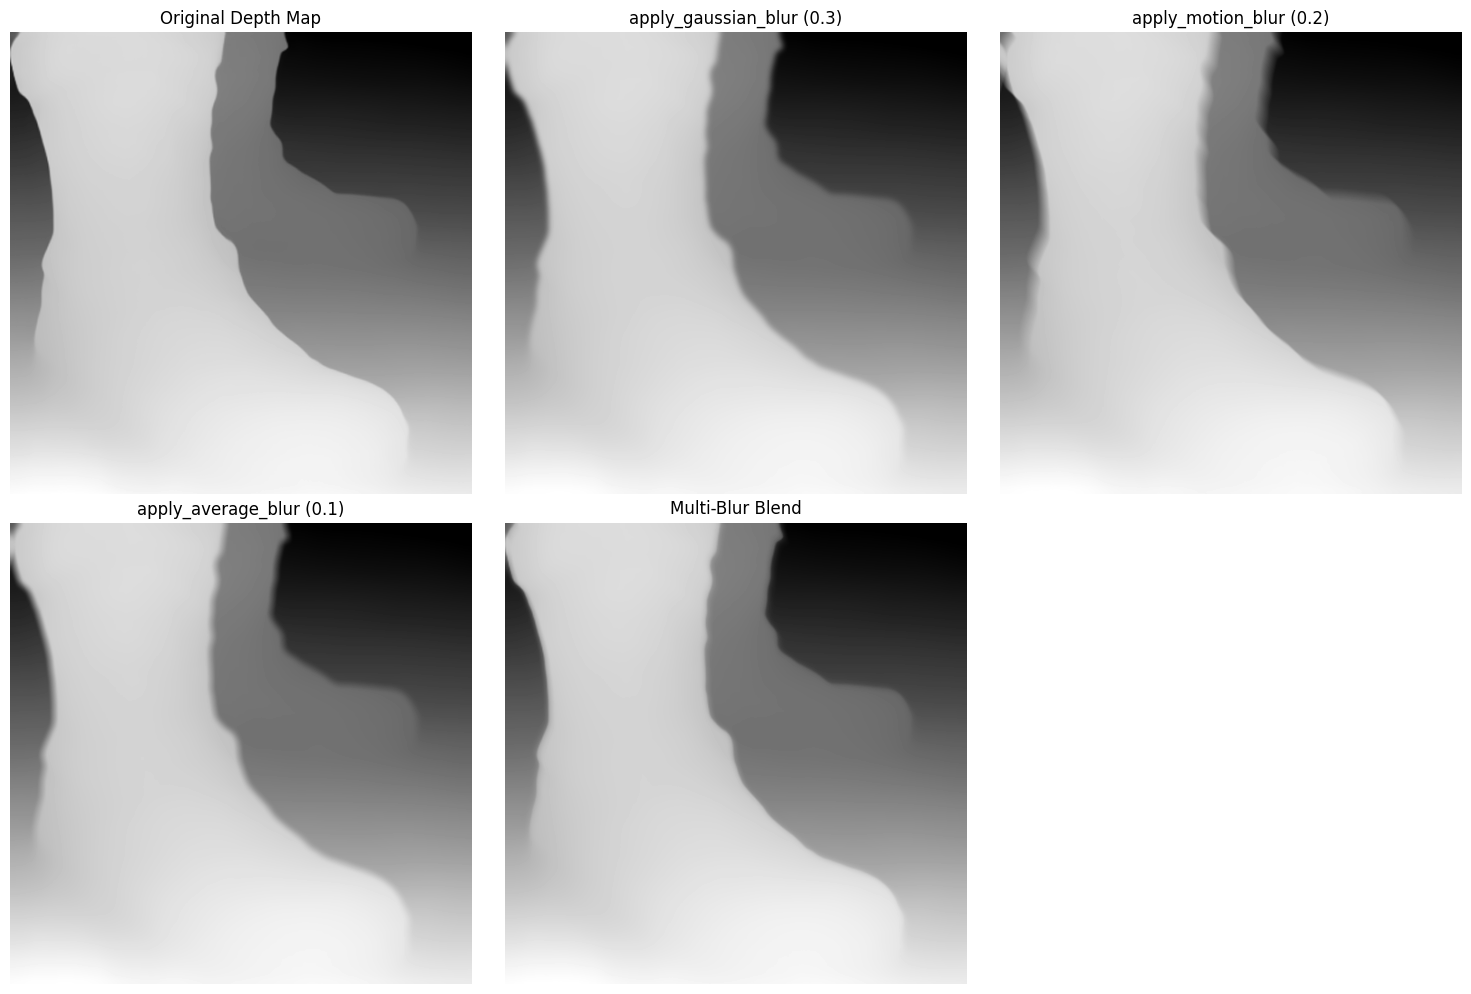

Saved multi-blur depth map to multi_blur_depth_map.png
You can now use this multi-blur depth map in your ControlNet pipeline
Load it with: multi_blur_depth_img = Image.open('multi_blur_depth_map.png').convert('RGB').resize((512, 512))


In [ ]:
# Example of using weighted blending with other blur techniques

def create_multi_blur_depth_map(original_depth_map, weights_and_blurs):
    """Creates a depth map by blending multiple blurred versions with the original.

    Args:
        original_depth_map: The original depth map (numpy array)
        weights_and_blurs: List of tuples (weight, blur_function, blur_params)
            - weight: Weight for this blur component (weights should sum to <= 1)
            - blur_function: Function reference to apply blur
            - blur_params: Dict of parameters to pass to the blur function

    Returns:
        Blended depth map combining multiple blur types
    """
    # Convert to float32 for processing
    result = np.zeros_like(original_depth_map, dtype=np.float32)
    
    # Track the total weight applied
    total_weight = 0
    
    # Apply each blur and add its weighted contribution
    for weight, blur_function, blur_params in weights_and_blurs:
        # Apply the blur function with its parameters
        blurred = blur_function(original_depth_map.copy(), **blur_params)
        
        # Add weighted contribution to result
        result += weight * blurred.astype(np.float32)
        total_weight += weight
    
    # If the weights don't sum to 1, apply the remaining weight to the original
    if total_weight < 1.0:
        result += (1.0 - total_weight) * original_depth_map.astype(np.float32)
    
    return result.astype(original_depth_map.dtype)

# Example usage
if __name__ == "__main__":
    # Load the depth map
    original_depth_map_path = "output/images/output_depth_map.png"
    original_depth_map_color = cv2.imread(original_depth_map_path, cv2.IMREAD_UNCHANGED)
    
    if original_depth_map_color is None:
        print(f"Error: Could not load the depth map from {original_depth_map_path}")
    else:
        original_depth_map = original_depth_map_color[:, :, 0]
        
        # Define blur combinations with weights
        blur_combinations = [
            # 30% Gaussian blur (moderate)
            (0.3, apply_gaussian_blur, {'ksize': (15, 15), 'sigmaX': 3}),
            # 20% Motion blur (slight)
            (0.2, apply_motion_blur, {'kernel_size': 15, 'angle': 45}),
            # 10% Average blur (subtle)
            (0.1, apply_average_blur, {'ksize': (10, 10)})
            # Remaining 40% will be original depth map
        ]
        
        # Create the multi-blur depth map
        multi_blur_depth_map = create_multi_blur_depth_map(original_depth_map, blur_combinations)
        
        # Visualize the results
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(original_depth_map, cmap='gray')
        plt.title("Original Depth Map")
        plt.axis('off')
        
        # Show each individual blur component
        for i, (weight, blur_function, blur_params) in enumerate(blur_combinations):
            blurred = blur_function(original_depth_map.copy(), **blur_params)
            plt.subplot(2, 3, i + 2)
            plt.imshow(blurred.astype(np.uint8), cmap='gray')
            plt.title(f"{blur_function.__name__} ({weight:.1f})")
            plt.axis('off')
        
        # Show the final blended result
        plt.subplot(2, 3, len(blur_combinations) + 2)
        plt.imshow(multi_blur_depth_map.astype(np.uint8), cmap='gray')
        plt.title("Multi-Blur Blend")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save the multi-blur depth map
        multi_blur_path = "multi_blur_depth_map.png"
        cv2.imwrite(multi_blur_path, multi_blur_depth_map.astype(np.uint8))
        print(f"Saved multi-blur depth map to {multi_blur_path}")
        
        # You can use this multi-blur depth map in your ControlNet pipeline
        print("You can now use this multi-blur depth map in your ControlNet pipeline")
        print(f"Load it with: multi_blur_depth_img = Image.open('{multi_blur_path}').convert('RGB').resize((512, 512))")